## Вступление

**Контекст**

Этот набор данных взят из Национального института диабета, заболеваний органов пищеварения и почек. Цель состоит в том, чтобы на основе диагностических измерений предсказать, есть ли у пациента диабет.

Ссылка на датасет: https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data

## Данные и переменные

Эти выборки из более крупной базы данных отбирались с учетом определенных ограничений. В частности, все пациенты - это женщины не моложе 21 года индейского происхождения из племени пима.

* Pregnancies: Количество беременностей

* Glucose: Концентрация глюкозы в плазме крови через 2 часа в пероральном тесте на толерантность к глюкозе

* BloodPressure: Диастолическое артериальное давление (мм рт. ст.)

* SkinThickness: Толщина кожной складки на трицепсе (мм)

* Insulin: Уровень инсулина в сыворотке крови через 2 часа (мкЕд / мл)

* BMI: Индекс массы тела (вес в кг / (рост в м) ^ 2)

* DiabetesPedigreeFunction: Функция родословной диабета

* Age: Возраст (лет)

* Outcome: Классовая переменная (0 или 1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.6 MB/s eta 0:00:00


In [4]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
link = '/content/drive/MyDrive/Analytics/Diabetes/'
data = pd.read_csv(link + 'diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA (Exploratory of Data Analysis)

In [6]:
data.shape

(768, 9)

In [7]:
data.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.000,0.000,1.00000,3.0000,6.00000,9.0000,10.00000,13.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,85.000,99.00000,117.0000,140.25000,167.0000,181.00000,196.00000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,54.000,62.00000,72.0000,80.00000,88.0000,90.00000,106.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.000,0.00000,23.0000,32.00000,40.0000,44.00000,51.33000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.000,0.00000,30.5000,127.25000,210.0000,293.00000,519.90000,846.00
BMI,768.0,31.992578,7.884160,0.000,23.600,27.30000,32.0000,36.60000,41.5000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.165,0.24375,0.3725,0.62625,0.8786,1.13285,1.69833,2.42
Age,768.0,33.240885,11.760232,21.000,22.000,24.00000,29.0000,41.00000,51.0000,58.00000,67.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000,0.00000,0.0000,1.00000,1.0000,1.00000,1.00000,1.00


In [8]:
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [9]:
data['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [10]:
def show_hists(data):
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))

    sns.histplot(data['Age'], kde=True, ax=ax[0][0])
    ax[0][0].set_title("Distribution of Ages", size=14)
    ax[0][0].set_xlabel("Age", size=12)
    ax[0][0].set_ylabel("Frequency", size=12)

    sns.histplot(data['DiabetesPedigreeFunction'], kde=True, ax=ax[0][1])
    ax[0][1].set_title("Distribution of DiabetesPedigreeFunction", size=14)
    ax[0][1].set_xlabel("DiabetesPedigreeFunction", size=12)
    ax[0][1].set_ylabel("Frequency", size=12)

    sns.histplot(data['BMI'], kde=True, ax=ax[1][0])
    ax[1][0].set_title("Distribution of BMI", size=14)
    ax[1][0].set_xlabel("BMI", size=12)
    ax[1][0].set_ylabel("Frequency", size=12)

    sns.histplot(data['Insulin'], kde=True, ax=ax[1][1])
    ax[1][1].set_title("Distribution of Insulin", size=14)
    ax[1][1].set_xlabel("Insulin", size=12)
    ax[1][1].set_ylabel("Frequency", size=12)

    sns.histplot(data['SkinThickness'], kde=True, ax=ax[2][0])
    ax[2][0].set_title("Distribution of SkinThickness", size=14)
    ax[2][0].set_xlabel("SkinThickness", size=12)
    ax[2][0].set_ylabel("Frequency", size=12)

    sns.histplot(data['BloodPressure'], kde=True, ax=ax[2][1])
    ax[2][1].set_title("Distribution of BloodPressure", size=14)
    ax[2][1].set_xlabel("BloodPressure", size=12)
    ax[2][1].set_ylabel("Frequency", size=12)

    sns.histplot(data['Glucose'], kde=True, ax=ax[3][0])
    ax[3][0].set_title("Distribution of Glucose", size=14)
    ax[3][0].set_xlabel("Glucose", size=12)
    ax[3][0].set_ylabel("Frequency", size=12)

    sns.histplot(data['Pregnancies'], kde=True, ax=ax[3][1])
    ax[3][1].set_title("Distribution of Pregnancies", size=14)
    ax[3][1].set_xlabel("Pregnancies", size=12)
    ax[3][1].set_ylabel("Frequency", size=12)

    plt.show()

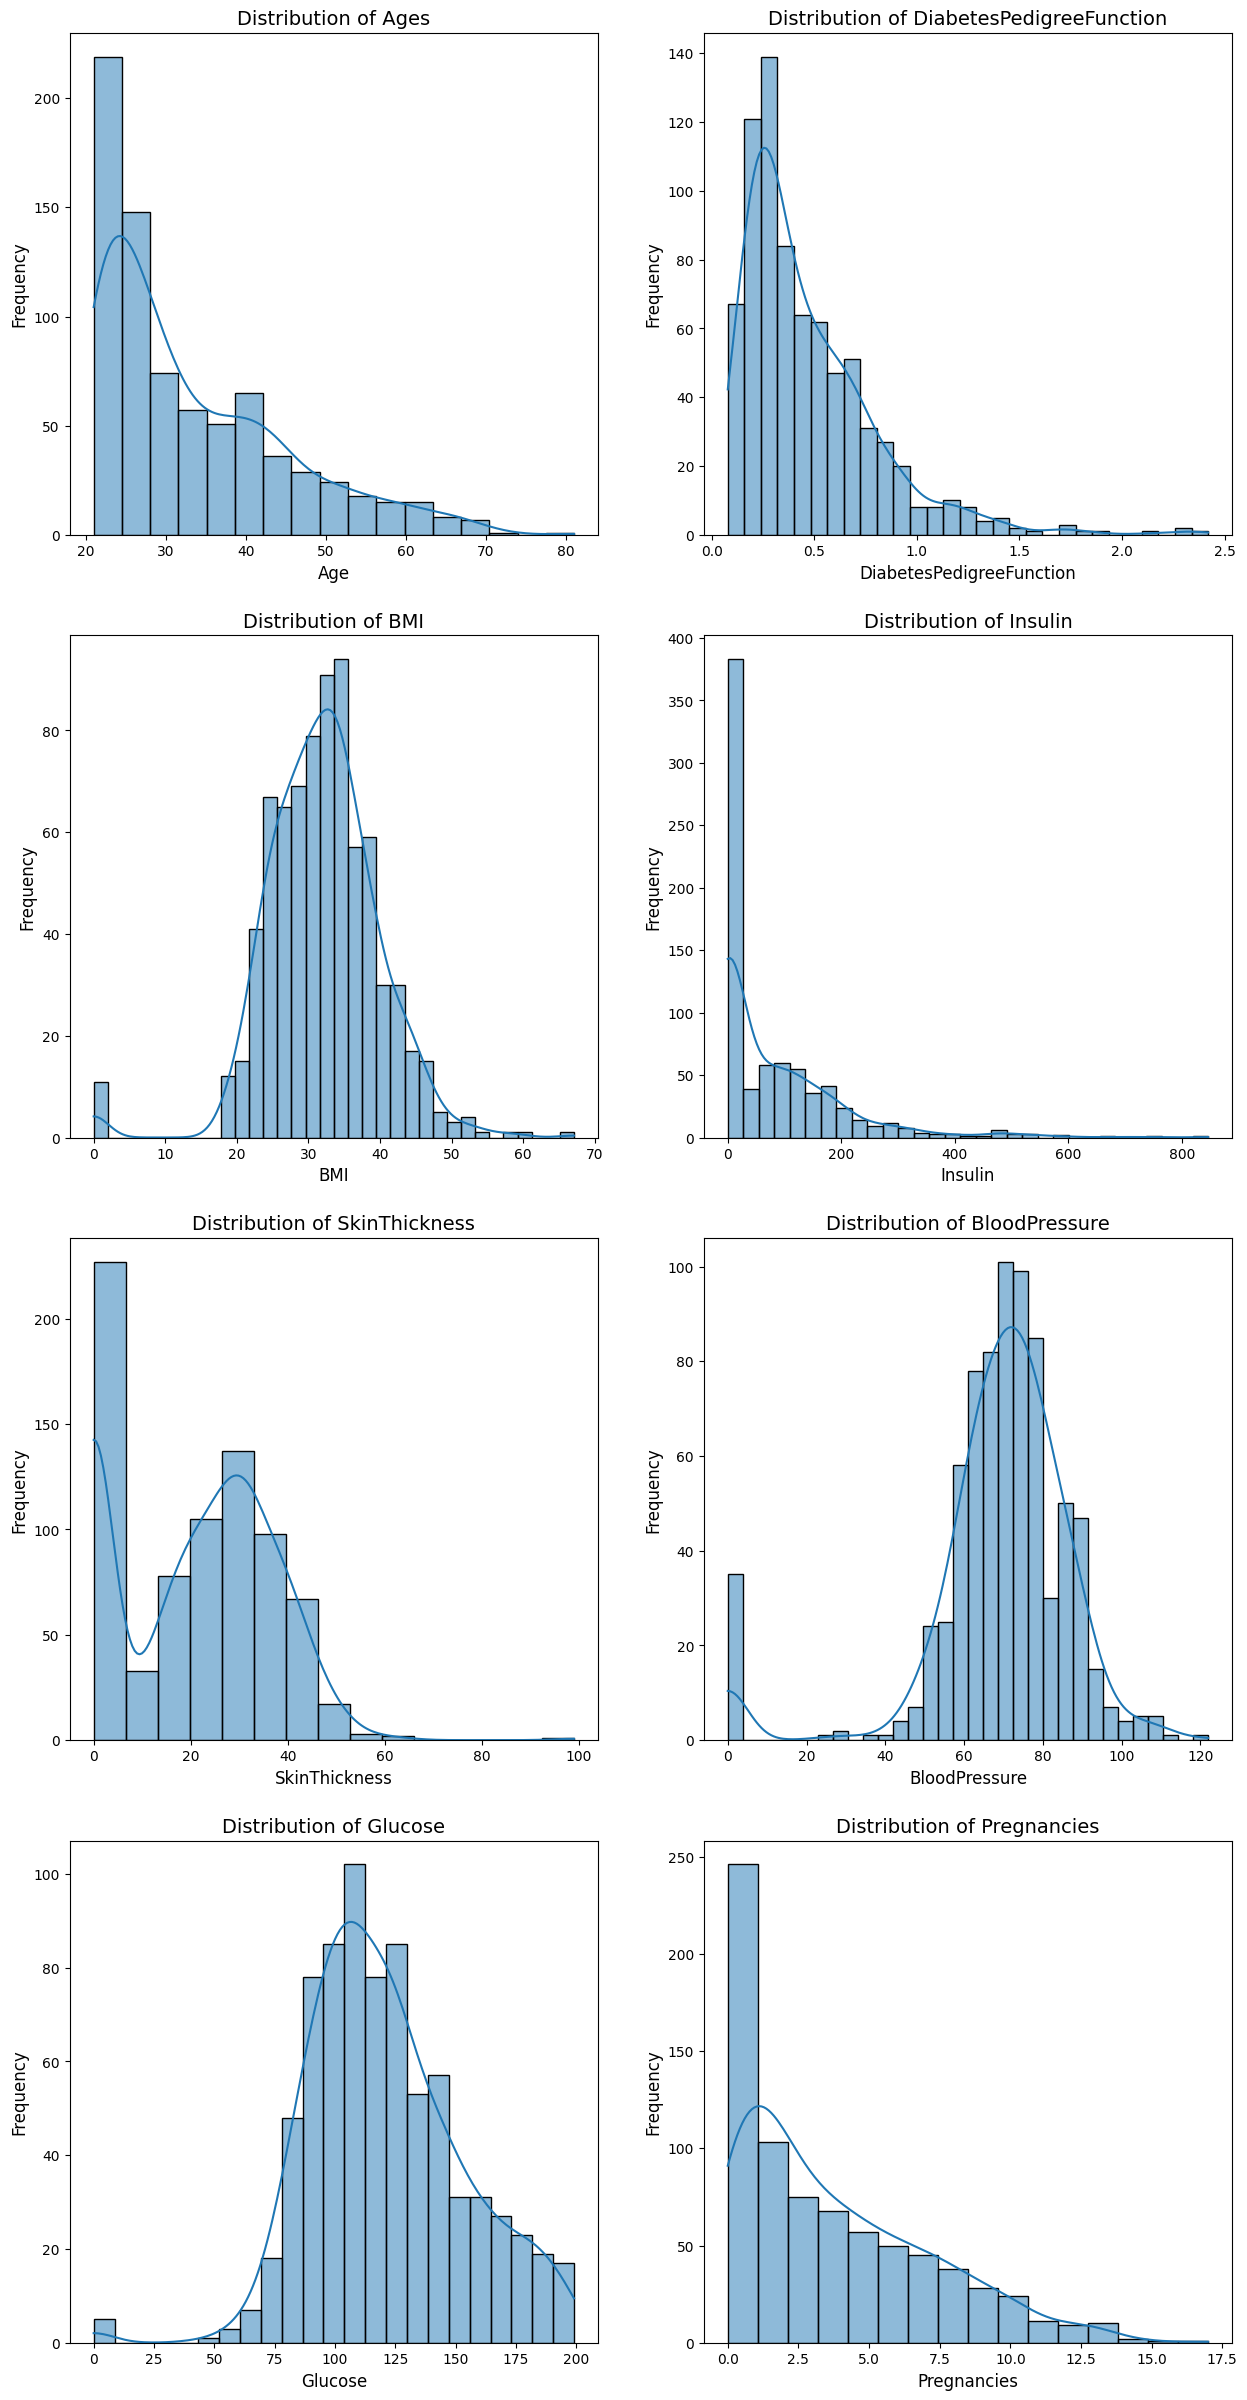

In [11]:
show_hists(data)

## Пропущенные значения и выбросы


In [12]:
numeric_columns = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]

data[numeric_columns] = data[numeric_columns].replace(0, np.NaN)

In [13]:
data.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Будем заменять пропущенные значения медианами.

In [14]:
def median_column(column):
    not_null_data = data[data[column].notnull()]
    not_null_data = not_null_data[[column, 'Outcome']] \
        .groupby(['Outcome'])[column] \
        .median().reset_index()
    return not_null_data[column]

In [15]:
for column in numeric_columns:
    data.loc[
        (data['Outcome'] == 0) & \
        (data[column].isnull() == 1), column
    ] = median_column(column)[0]
    data.loc[
        (data['Outcome'] == 1) & \
        (data[column].isnull() == 1), column
    ] = median_column(column)[1]

Теперь поищем выбросы.

In [16]:
for feature in data:
    Q1 = data[feature].quantile(0.05)
    Q3 = data[feature].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if data[(data[feature] > upper)].any(axis=None):
        print(f"{feature}: YES")
    else:
        print(f"{feature}: NO")

Pregnancies: NO
Glucose: NO
BloodPressure: NO
SkinThickness: YES
Insulin: YES
BMI: NO
DiabetesPedigreeFunction: NO
Age: NO
Outcome: NO


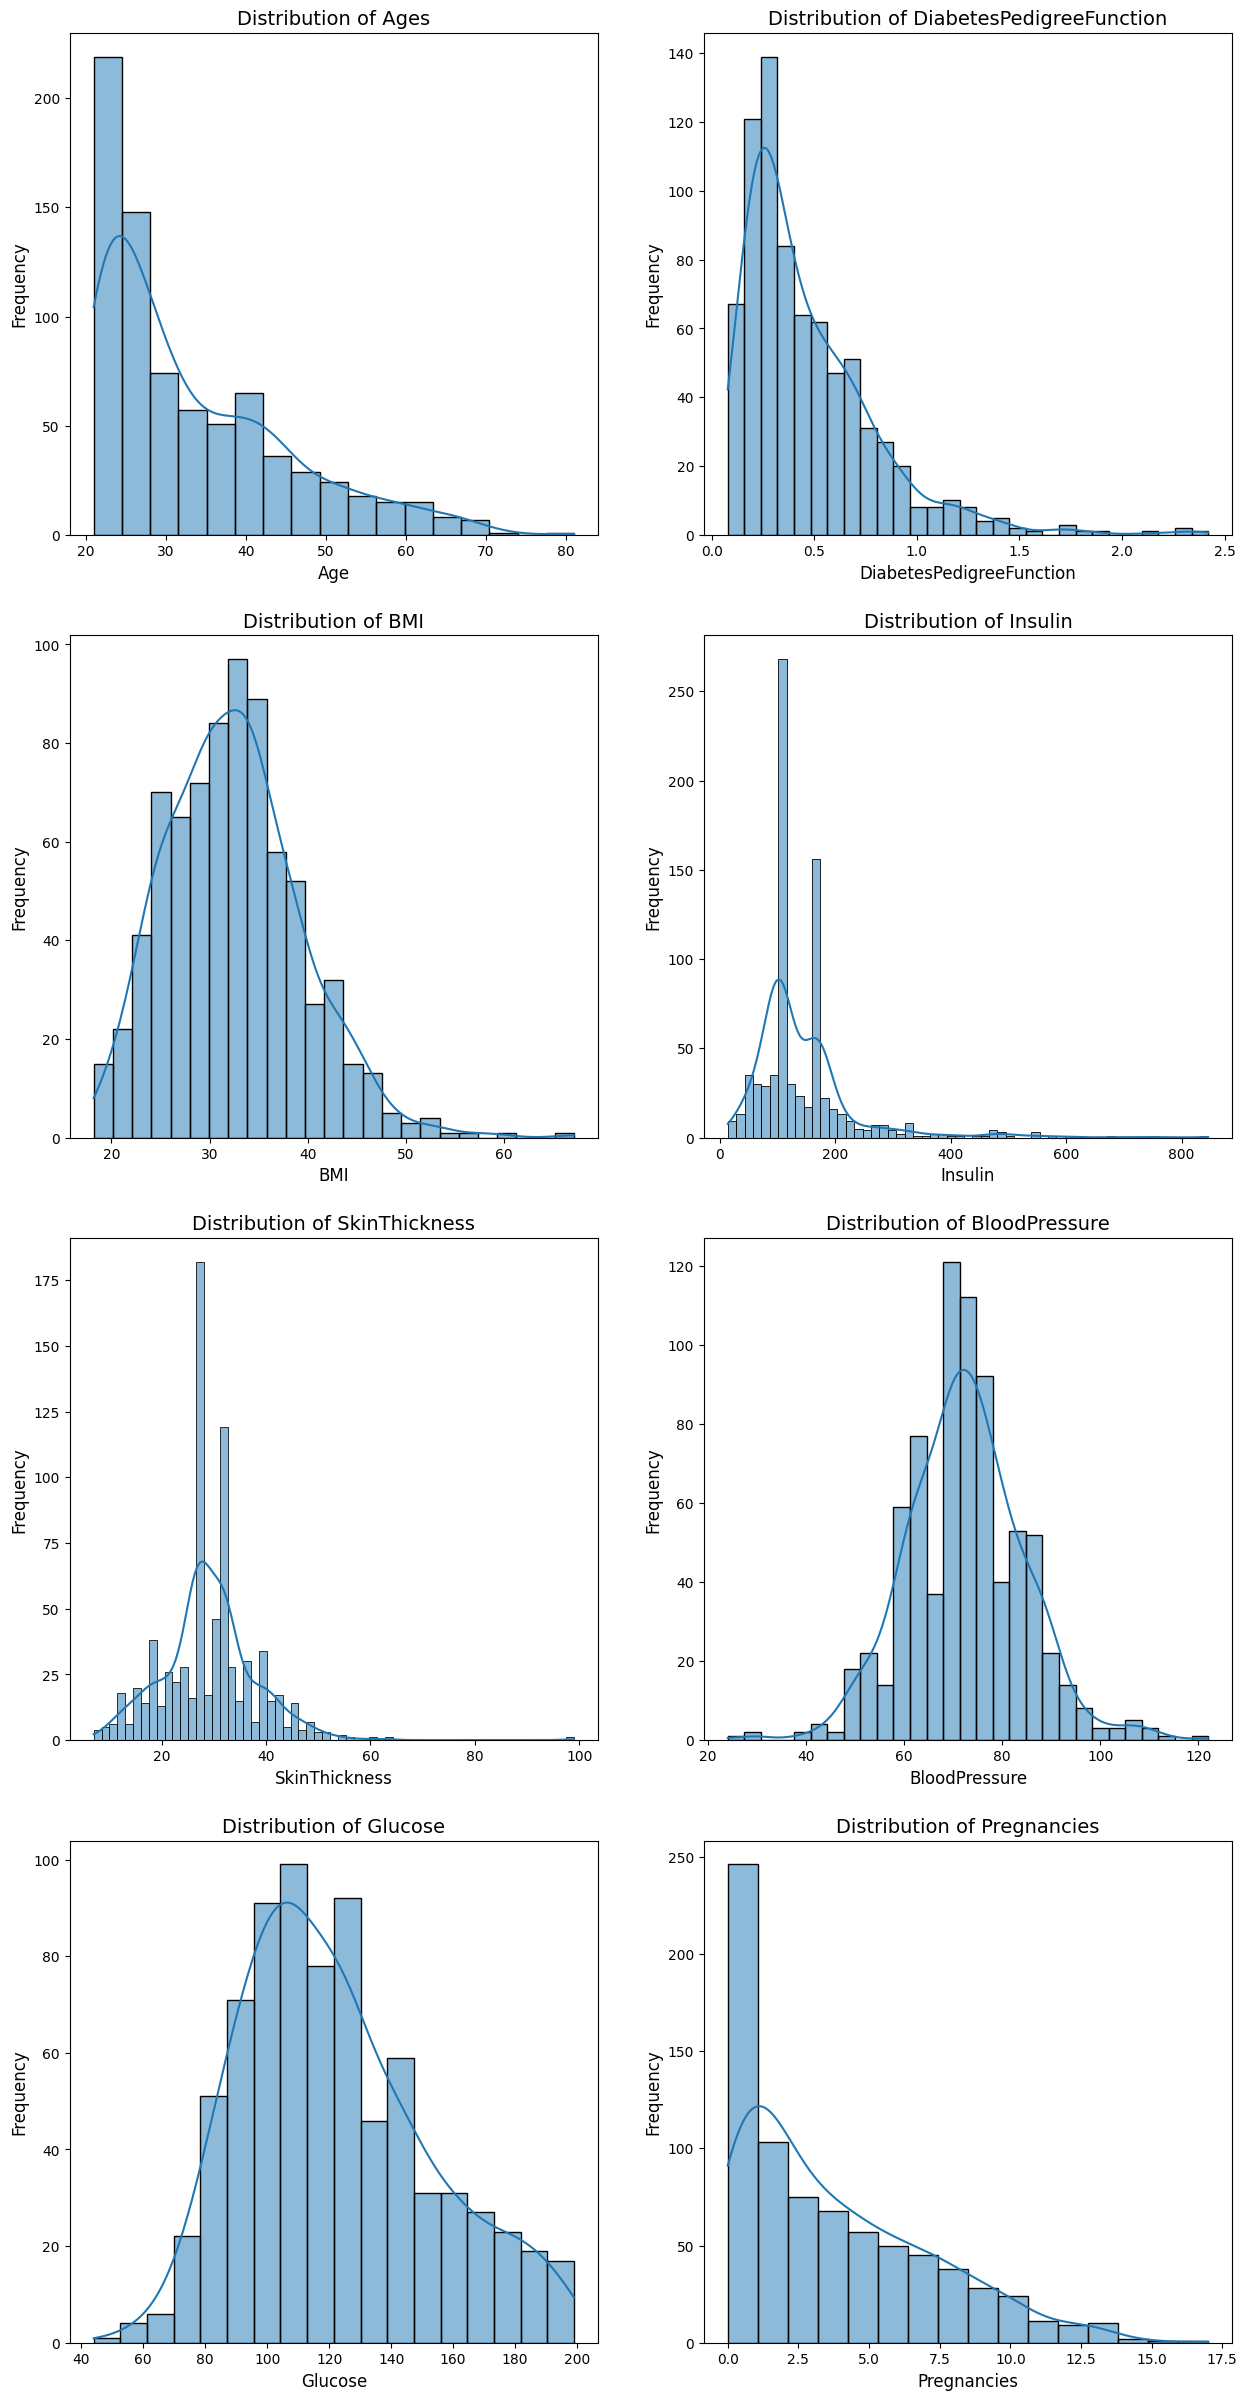

In [17]:
show_hists(data)

## Data Preprocessing

In [18]:
y = data['Outcome']
X = data.drop(['Outcome'], axis=1)
columns = X.columns
index = X.index

In [19]:
transformer = ColumnTransformer([
    ('StandardScaler', StandardScaler(), X.columns)
])
X = transformer.fit_transform(X)
X = pd.DataFrame(X, columns=columns, index=index)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.864625,-0.032180,0.665181,0.311604,0.169483,0.468492,1.425995
1,-0.844885,-1.204727,-0.528124,-0.010112,-0.440843,-0.848549,-0.365061,-0.190672
2,1.233880,2.014265,-0.693438,0.327535,0.311604,-1.328478,0.604397,-0.105584
3,-0.844885,-1.073339,-0.528124,-0.685405,-0.536303,-0.630399,-0.920763,-1.041549
4,-1.141852,0.503310,-2.677212,0.665181,0.294758,1.551096,5.484909,-0.020496


Обучение моделей

In [20]:
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=123)))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier(random_state=123)))
models.append(('RandomForest', RandomForestClassifier(random_state=123)))
models.append(('SVM', SVC(random_state=123)))
models.append(('XGB', GradientBoostingClassifier(random_state=123)))
models.append(('LightGBM', LGBMClassifier(verbose=-1, random_state=123)))
models.append(('CatBoost', CatBoostClassifier(verbose=False, random_state=123)))

In [21]:
for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    results = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"{name}: {round(results.mean(), 4)} ({round(results.std(), 4)})")
del models

LogisticRegression: 0.8593 (0.0228)
KNeighborsClassifier: 0.8731 (0.015)
DecisionTree: 0.856 (0.0203)
RandomForest: 0.9433 (0.0114)
SVM: 0.9015 (0.0105)
XGB: 0.9531 (0.0069)
LightGBM: 0.9519 (0.0144)
CatBoost: 0.9498 (0.0121)


### Random Forest Tuning

In [22]:
params_rf = {
    "n_estimators" :[100, 300, 500, 700],
    "max_features": [3, 5, 7, 9],
    "min_samples_split": [2, 4, 6, 8],
    "max_depth": [3, 5, 7, None]
}

model_rf = RandomForestClassifier(random_state=123)
search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0).fit(X, y)
search_rf.best_params_

{'max_depth': 5,
 'max_features': 9,
 'min_samples_split': 2,
 'n_estimators': 700}

In [23]:
model_rf_tuned = RandomForestClassifier(**search_rf.best_params_).fit(X, y)
cross_val_score(model_rf_tuned, X, y, cv=5, scoring='roc_auc').mean()

0.9553941299790356

In [24]:
def feature_importance_show(model):
    feature_imporance = pd.Series(
        model.feature_importances_, index=columns
    ).sort_values(ascending=False)

    sns.barplot(x=feature_imporance, y=feature_imporance.index)
    plt.xlabel('Significance Score Of Variables')
    plt.ylabel('Variables')
    plt.title("Variable Severity Levels")
    plt.show()

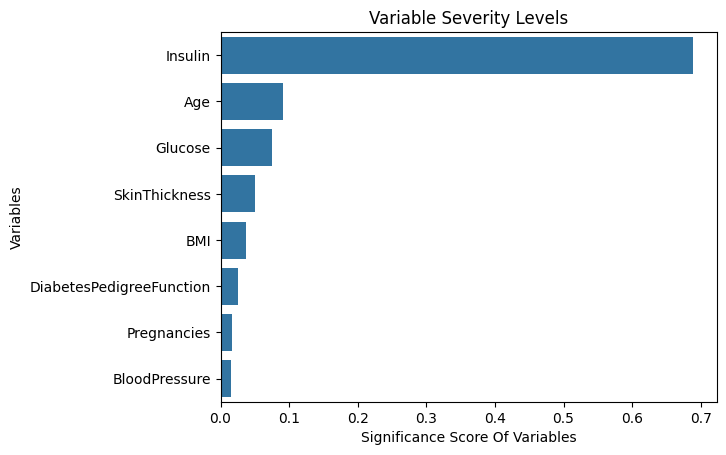

In [25]:
feature_importance_show(model_rf_tuned)

### XGB Tuning

In [26]:
params_xgb = {
    "learning_rate": [0.01, 0.05, 0.1, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 4),
    "max_depth":[3, 5, 8],
    "subsample":[0.4, 0.7, 1.0],
    "n_estimators": [100, 300, 500, 700]
}

model_xgb = GradientBoostingClassifier(random_state=123)
search_xgb = GridSearchCV(model_xgb, params_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0).fit(X, y)
search_xgb.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_split': 0.1,
 'n_estimators': 100,
 'subsample': 1.0}

In [27]:
model_xgb_tuned = GradientBoostingClassifier(**search_xgb.best_params_).fit(X,y)
cross_val_score(model_xgb_tuned, X, y, cv = 5, scoring='roc_auc').mean()

0.955183787561146

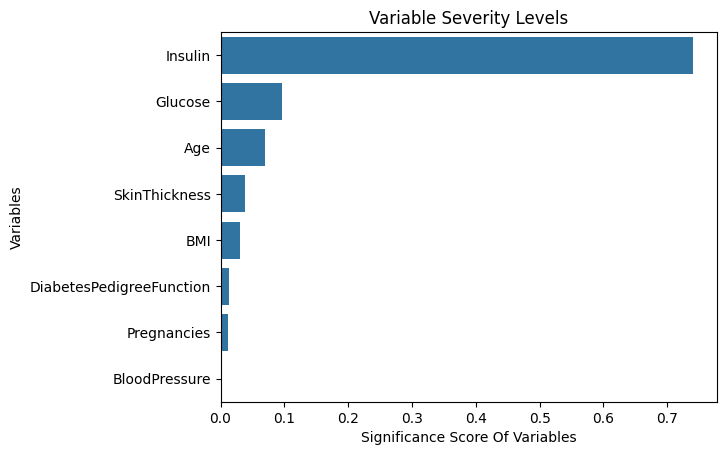

In [28]:
feature_importance_show(model_xgb_tuned)

### LightGBM Tuning

In [29]:
params_lgbm = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 700],
    "max_depth":[3, 5, 8]
}

lgbm = LGBMClassifier(verbose=-1, random_state=123)
search_lgbm = GridSearchCV(lgbm, params_lgbm, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0).fit(X, y)
search_lgbm.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300}

In [32]:
lgbm_tuned = LGBMClassifier(**search_lgbm.best_params_, verbose=-1).fit(X, y)
cross_val_score(lgbm_tuned, X, y, cv=5, scoring='roc_auc').mean()

0.956779175401817

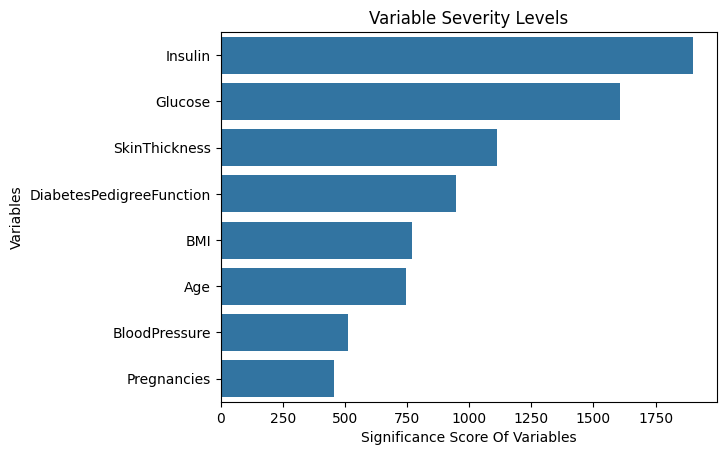

In [33]:
feature_importance_show(lgbm_tuned)

## Выводы

Лучшие результаты, конечно же, у ансамблей.